## Project Overview

This project is using ports datasets containing shape files which indicate geo-cordinates of each port near Halifax, NS and the AISData.csv file contains coordinates of visits to each port. Following are objectives of this project.

- Finding all the vessels that visited ports in the shape file, and creating a buffer with an appropriate radius around the shape of each all polygons in the shapefile. Second is finding all the AIS messages (from AIS data) that intersect with these ports.
- Showing the density (i.e., density is the number of AIS messages in a port), of each port on a map by using a colour-coded map.
- Dividing the AIS data into data frames with a one-hour interval and repeating above objectives for all of the sub-dataframe and saving all generated plots in folder.
- Creating a temporal chart for the density of messages in that selected port, where x is the time and each snapshot of the time has the density of port at a specific hour.
- Using concept drift methods on above step and finding out if there is any drift in the data that can be detected.
- Clustering the ports based on their message density using DBSCAN and categorize the ports based on traffic (message density).

In [1]:
#import libraries
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from skmultiflow.drift_detection import PageHinkley
from skmultiflow.drift_detection import DDM
from skmultiflow.drift_detection.adwin import ADWIN
from skmultiflow.drift_detection.eddm import EDDM
from skmultiflow.drift_detection.base_drift_detector import BaseDriftDetector
import datetime
import os
import warnings

In [2]:
warnings.filterwarnings('ignore')
df_AISData=pd.read_csv('AISData.csv')
gdf_AISData = gpd.GeoDataFrame(df_AISData,
                                crs={'init': 'epsg:4326'},
                                geometry=[shapely.geometry.Point(xy) for xy in zip(df_AISData.x, df_AISData.y)])
shape_Data=gpd.read_file('shapefile.shp')
df_ports=shape_Data.set_index(['port_name'])

### 1. Finding all the vessels that visited ports in the provided shapefile.  
#### Creating a buffer with an appropriate radius around the shape of each all polygons in the shapefile. 
In the following figure, ports are indicated by blue circle. Buffer is indicated by red circle around blue circle, and visits to ports are indicated by green color points.

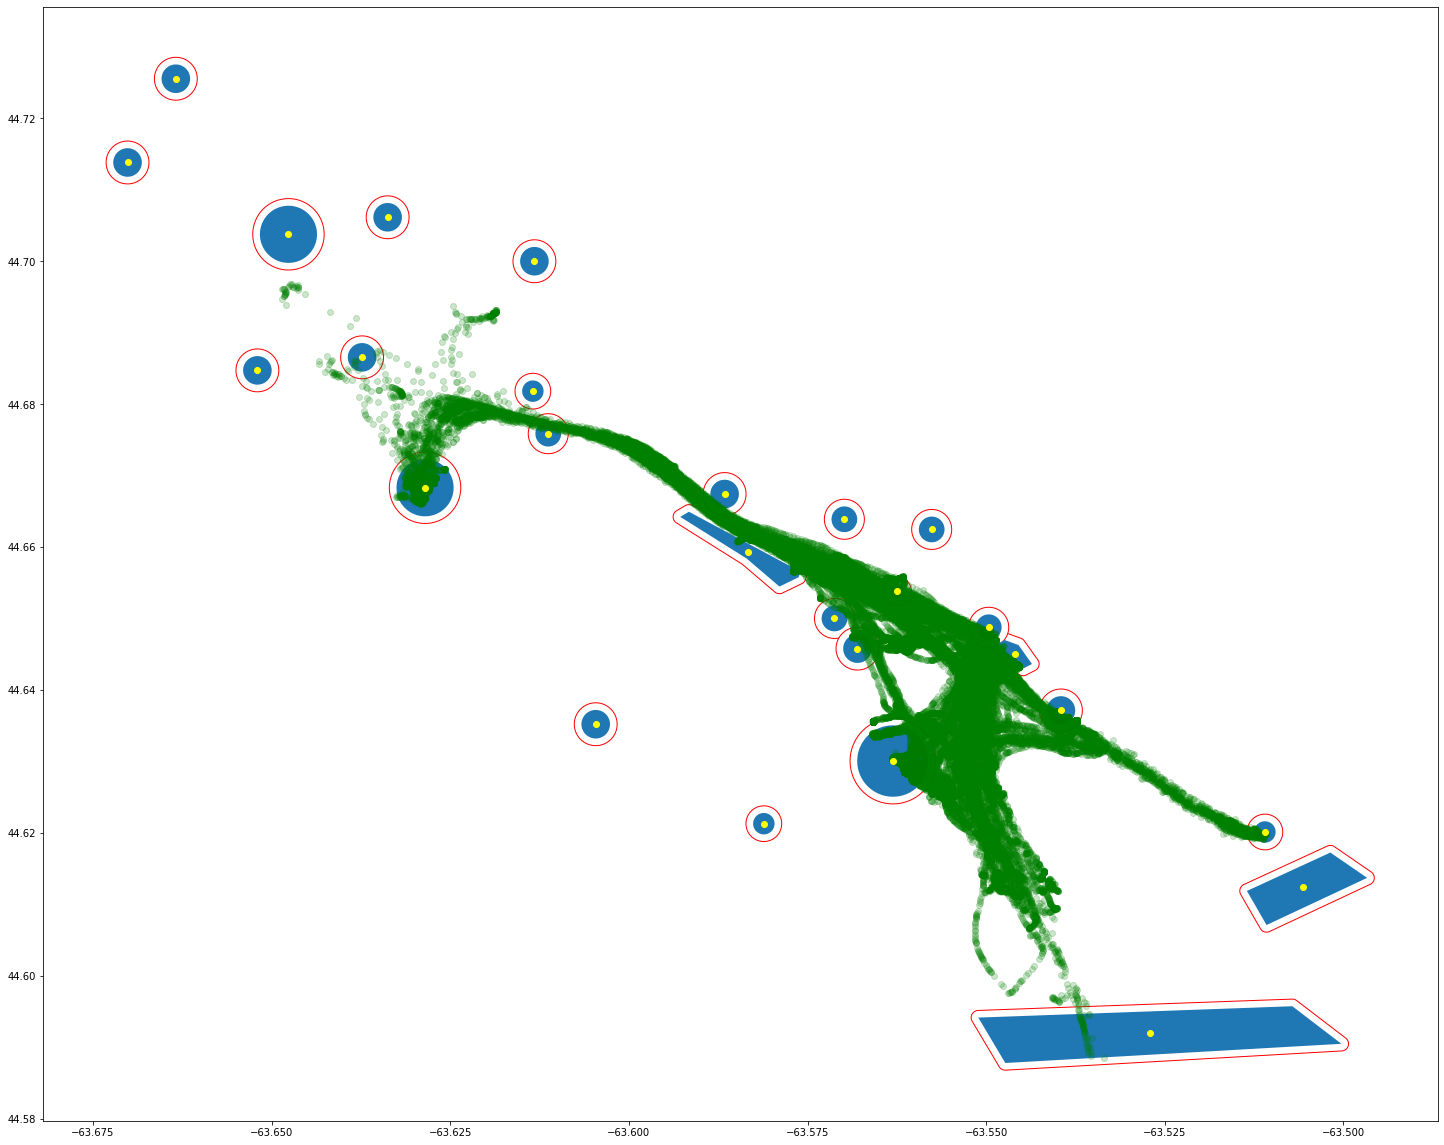

In [3]:
def plot_all_vessels(df_ports,gdf_AISData,fig,ax,iteration):
    #following iteration condition only run one time when function is triggered within loop
    #this logic is used for improving performance in loop (objective 3 of project)
    if(iteration==0):
        array_Centroids = []
        array_Buffers = []
        for port in df_ports.index.values:
            #setting centroid of each port
            portCentroid = df_ports.loc[[port],:].centroid[0]
            #setting buffer with an appropriate radius around the shape of each polygon
            portBuffer=df_ports.loc[[port],:].geometry.buffer(0.0010)[0]
            array_Centroids.append(portCentroid)
            array_Buffers.append(portBuffer)

        gpd.GeoSeries(array_Buffers).plot(ax=ax,edgecolor='red',color='white')

        df_ports.loc[df_ports.index.values,:].plot(ax=ax)
    
    gdf_AISData.plot(ax=ax,color='g',alpha=0.2)
    
    if(iteration==0):
        gpd.GeoSeries(array_Centroids).plot(ax=ax,color='yellow')
    
    return ax.get_figure()

fig, ax = plt.subplots(figsize=(25,25))
fig = plot_all_vessels(df_ports,gdf_AISData,fig,ax,0)

#### Finding all the AIS messages (from AIS data) that intersect with these ports using color code map
All AIS messages that intersect with ports are highlighted with different color codes [1]. Essentially the following code look for the port coodinates and AIS message coordinates and applying join basis of that similarity. When a corresponding AIS message is found, it is plotted on graph. 

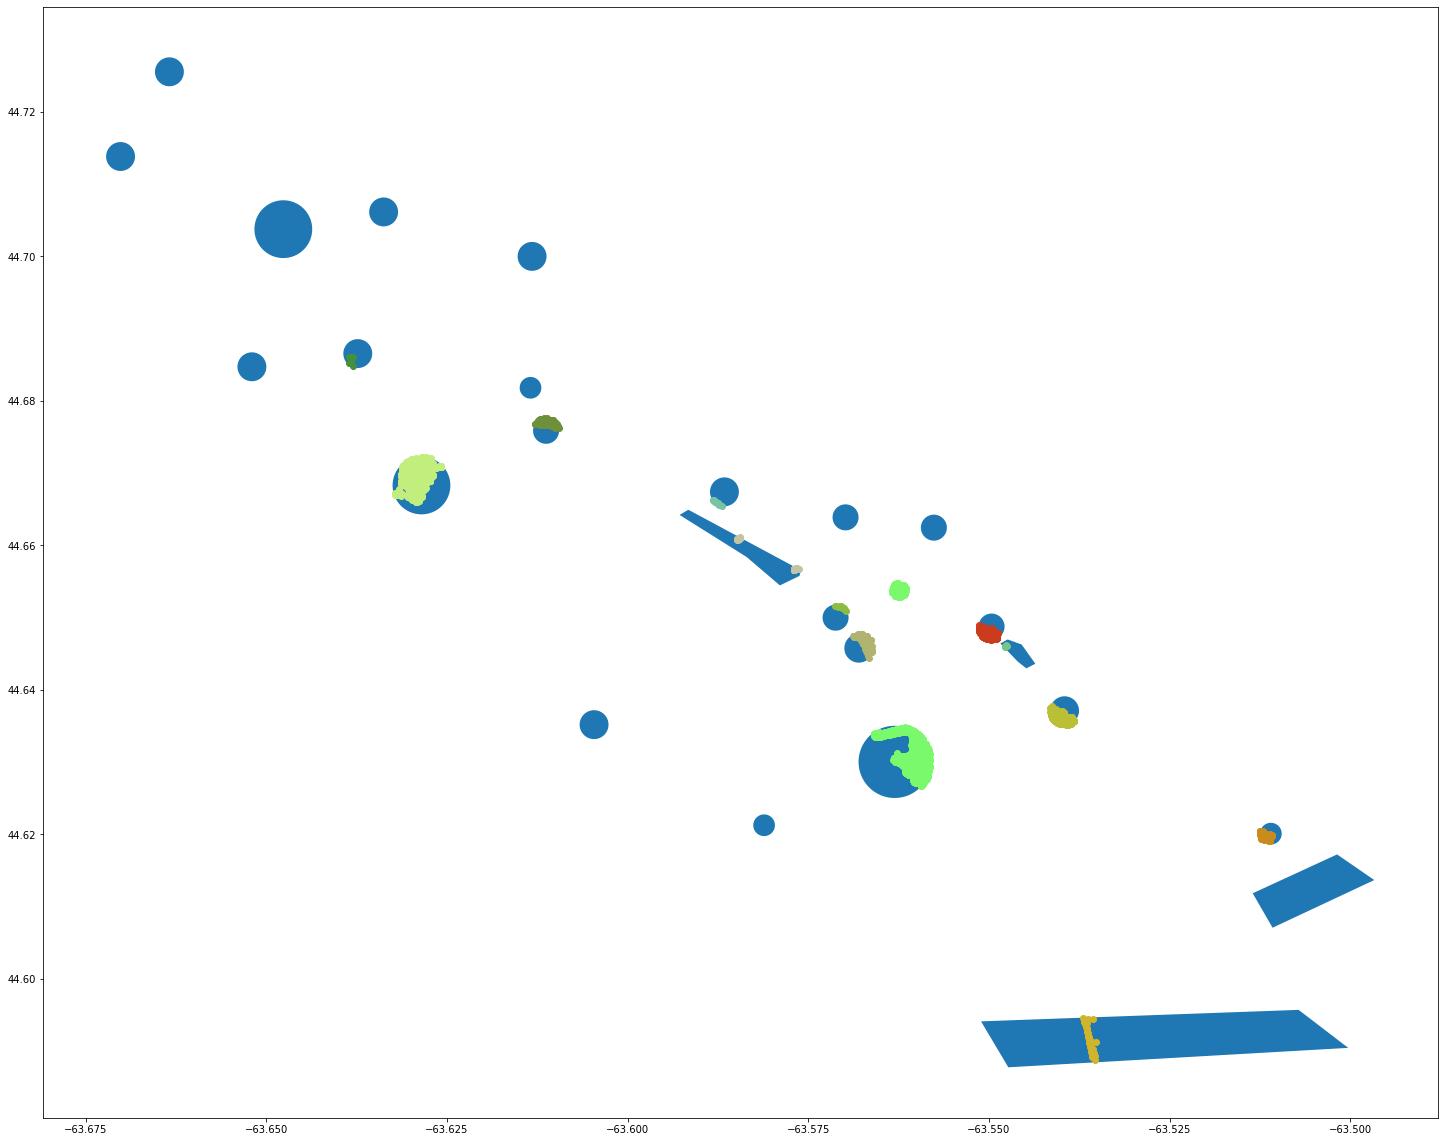

In [4]:
def plot_message_intersection_with_ports(df_ports,gdf_AISData,fig,ax,iteration):
    join_ais_port=gpd.sjoin(gdf_AISData,df_ports,op='within',how='inner')
    #initialize different color codes
    color_codes=['#ca3c1d','#ca8b1d','#d0b42b','#babf36','#b1b470','#c2c4a3','#c1ee7d','#8cbc44','#6e903b','#44903b',
                 '#7bf96c','#7bf96c','#76c48a','#76c4a2','#878787','#b05d5d','#933333','#588385','#5acbb8','#5ab1cb',
                 '#004b62','#010c1d','#8686cc','#78589c','#a01ba4','#ff70e1','#aa0086','#aa005d','#a50640','#a14e6c',
                 '#fccedf','#b44761','#47b48e','#a79444','#685b25','#28611e','#708793']
    
    #following iteration condition only run one time when function is triggered within loop
    #this logic is used for improving performance in loop
    if(iteration==0):
        df_ports.loc[df_ports.index.values,:].plot(ax=ax)
        df_ports["density"] = 0
    
    index=0
    for port in set(join_ais_port['index_right']):
        port_ais_data=join_ais_port.loc[join_ais_port['index_right']==port,:]
        if port_ais_data.shape[0]>0:
            #incrementing density value in dataframe for every iteration
            df_ports["density"][port]=df_ports["density"][port]+port_ais_data.shape[0]
            port_ais_data.plot(ax=ax,color=color_codes[index])
            index=index+1
    return ax.get_figure()

fig, ax = plt.subplots(figsize=(25,25))
fig = plot_message_intersection_with_ports(df_ports,gdf_AISData,fig,ax,0)

### 2. Showing the density (i.e., number of AIS messages in a port), on each port 
A column named 'density' is added to dataframe showing number of AIS messages in one port. Following this dataframe, the figure represents color-coded map showing density of visits for each of ports. By comparing datafram and figure it can be seen that port7 has highest number of density that outweighs the total density of other ports.

In [5]:
df_ports

,field_1,size,geometry,density
port_name,,,,
pointpolygon,0,0.0000,"POLYGON ((-63.59160304069519 44.6649292254607,...",153
port1,1,0.0018,"POLYGON ((-63.569431 44.649993, -63.5694396674...",13
port2,2,0.0018,"POLYGON ((-63.60949000000001 44.675853, -63.60...",119
ind,3,0.0000,POLYGON ((-63.54742169380188 44.64697911403847...,5
port5,4,0.0018,"POLYGON ((-63.568048 44.663875, -63.5680566674...",0
port6,5,0.0018,"POLYGON ((-63.555828 44.662453, -63.5558366674...",0
port7,6,0.0018,"POLYGON ((-63.547843 44.648763, -63.5478516674...",703250
south_enterance,7,0.0000,POLYGON ((-63.50715637207031 44.59572358282151...,39
auto_port,8,0.0015,"POLYGON ((-63.50949499999999 44.62011, -63.509...",2068


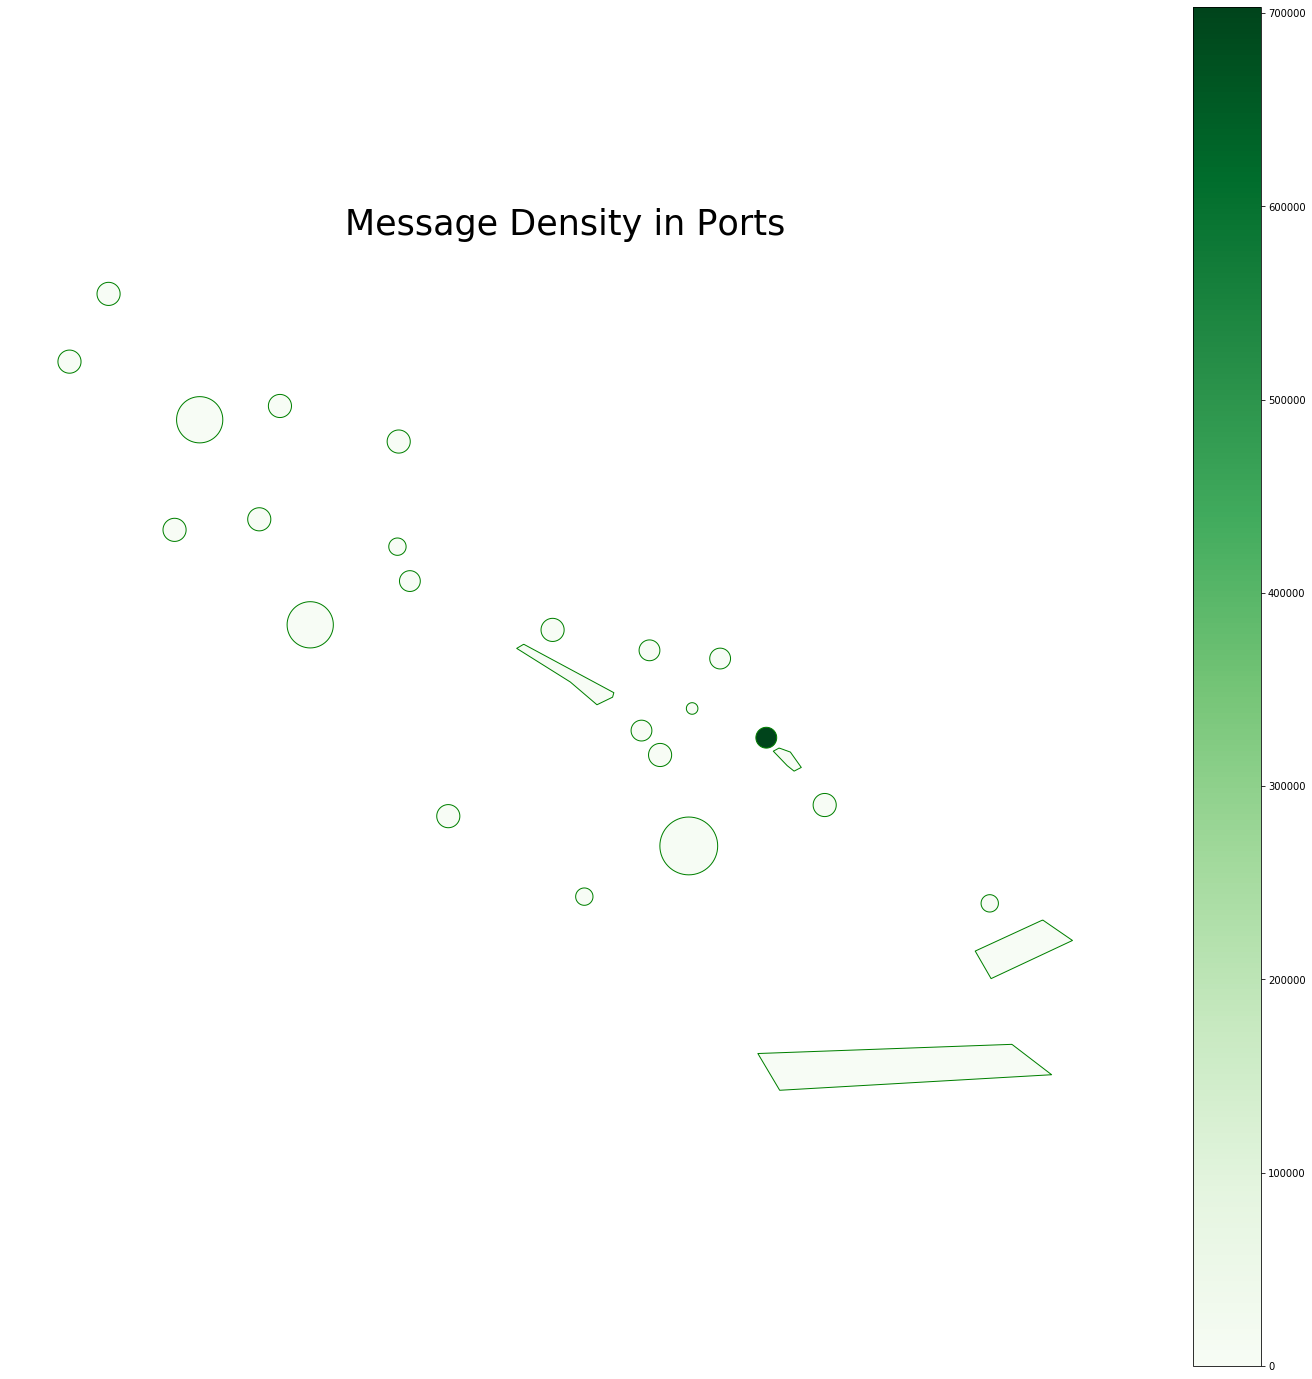

In [6]:
def plot_message_density(df_ports,fig,ax,iteration):
    min_value = df_ports["density"].min()
    max_value = df_ports["density"].max()

    ax.set_title('Message Density in Ports', fontdict={'fontsize': '35', 'fontweight' : '5'})
    ax.axis('off')

    df_ports.plot(column='density', cmap='Greens', linewidth=1, ax=ax, edgecolor='Green')
    #this logic prevents color bar duplication in every iteration in loop
    if(iteration==0):
        scalar_mappable = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=min_value, vmax=max_value))
        fig.colorbar(scalar_mappable)
    
    return ax.get_figure()

fig, ax = plt.subplots(figsize=(25,25))
fig = plot_message_density(df_ports,fig,ax,0)

### 3. Dividing the AIS data into data frames with a one-hour interval, repeating steps mentioned in objective 1 and 2 and saving figures in folders.

The data is divided into one hour interval considering date and hour. Three directories will be automatically created on project's root folder to store images. In previous part, functions are created to minimize the code, therefore these function are called here, and code is optimized to for working in loop.

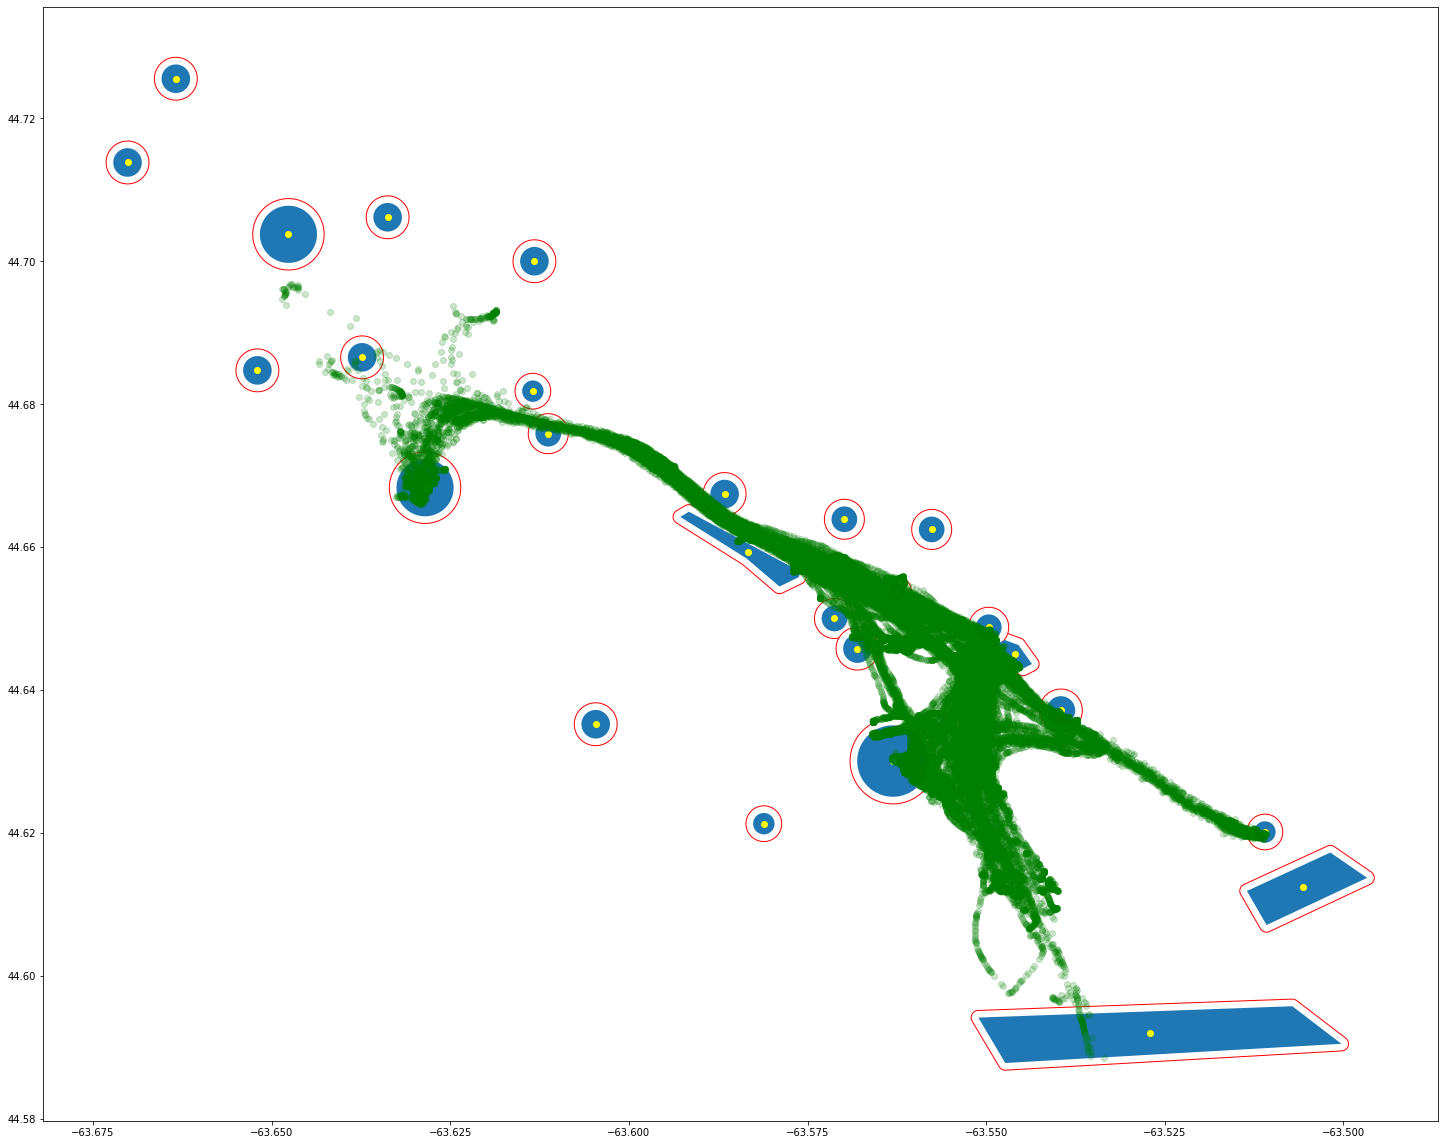

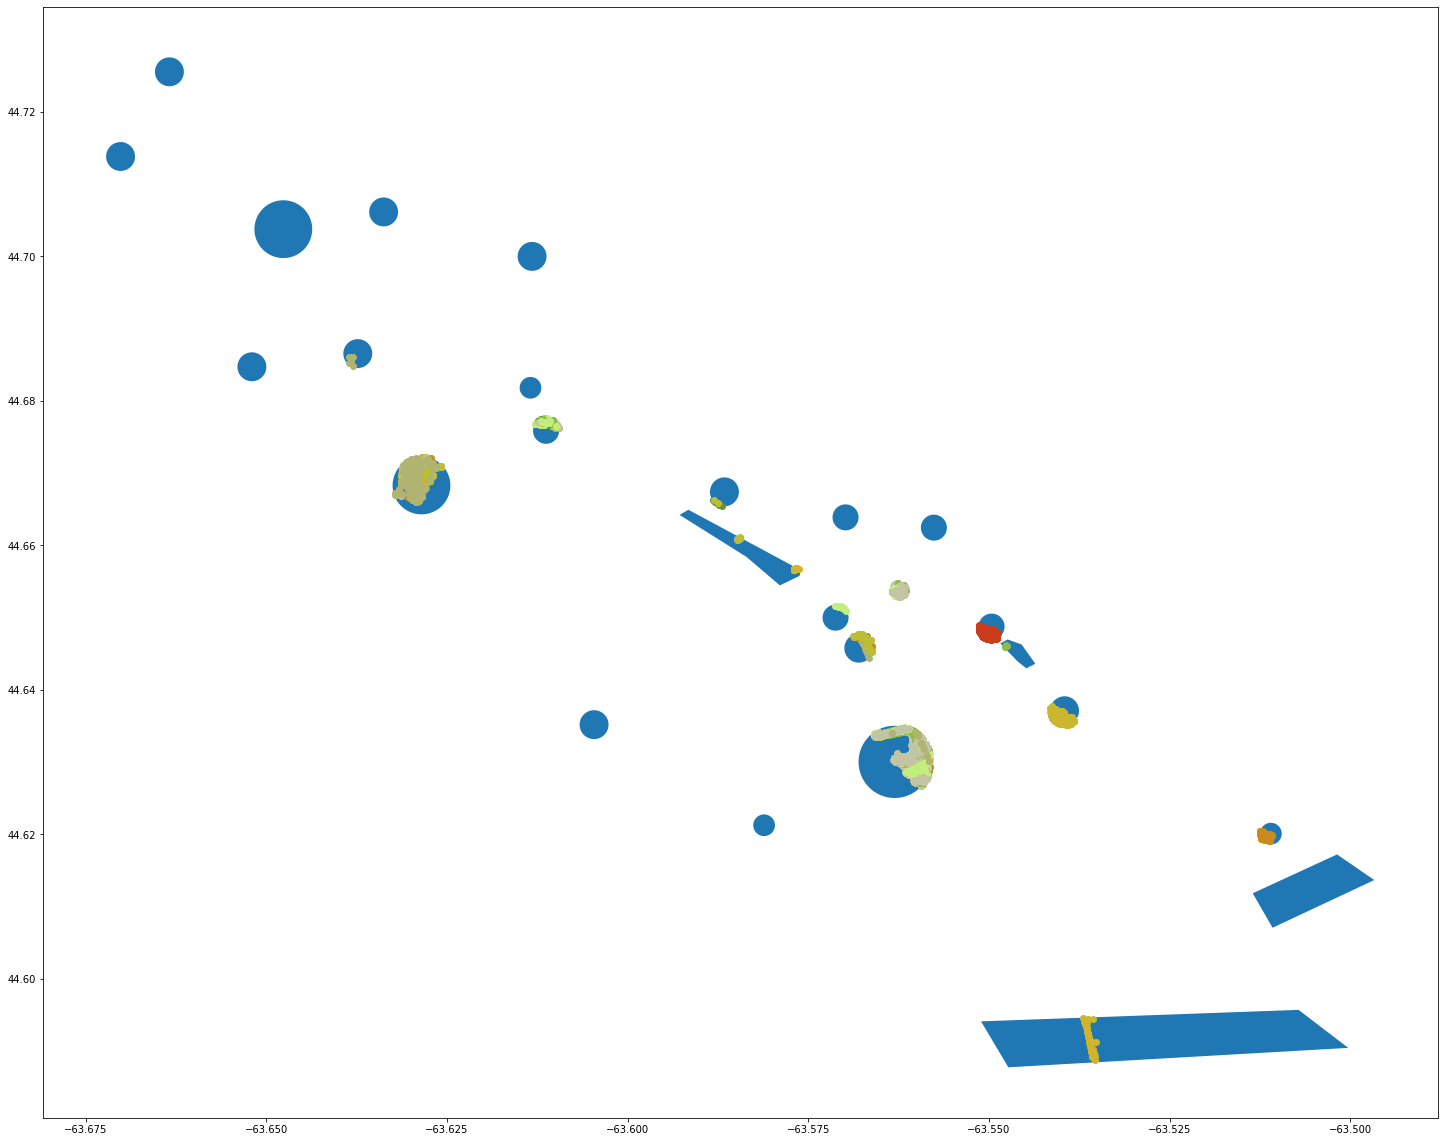

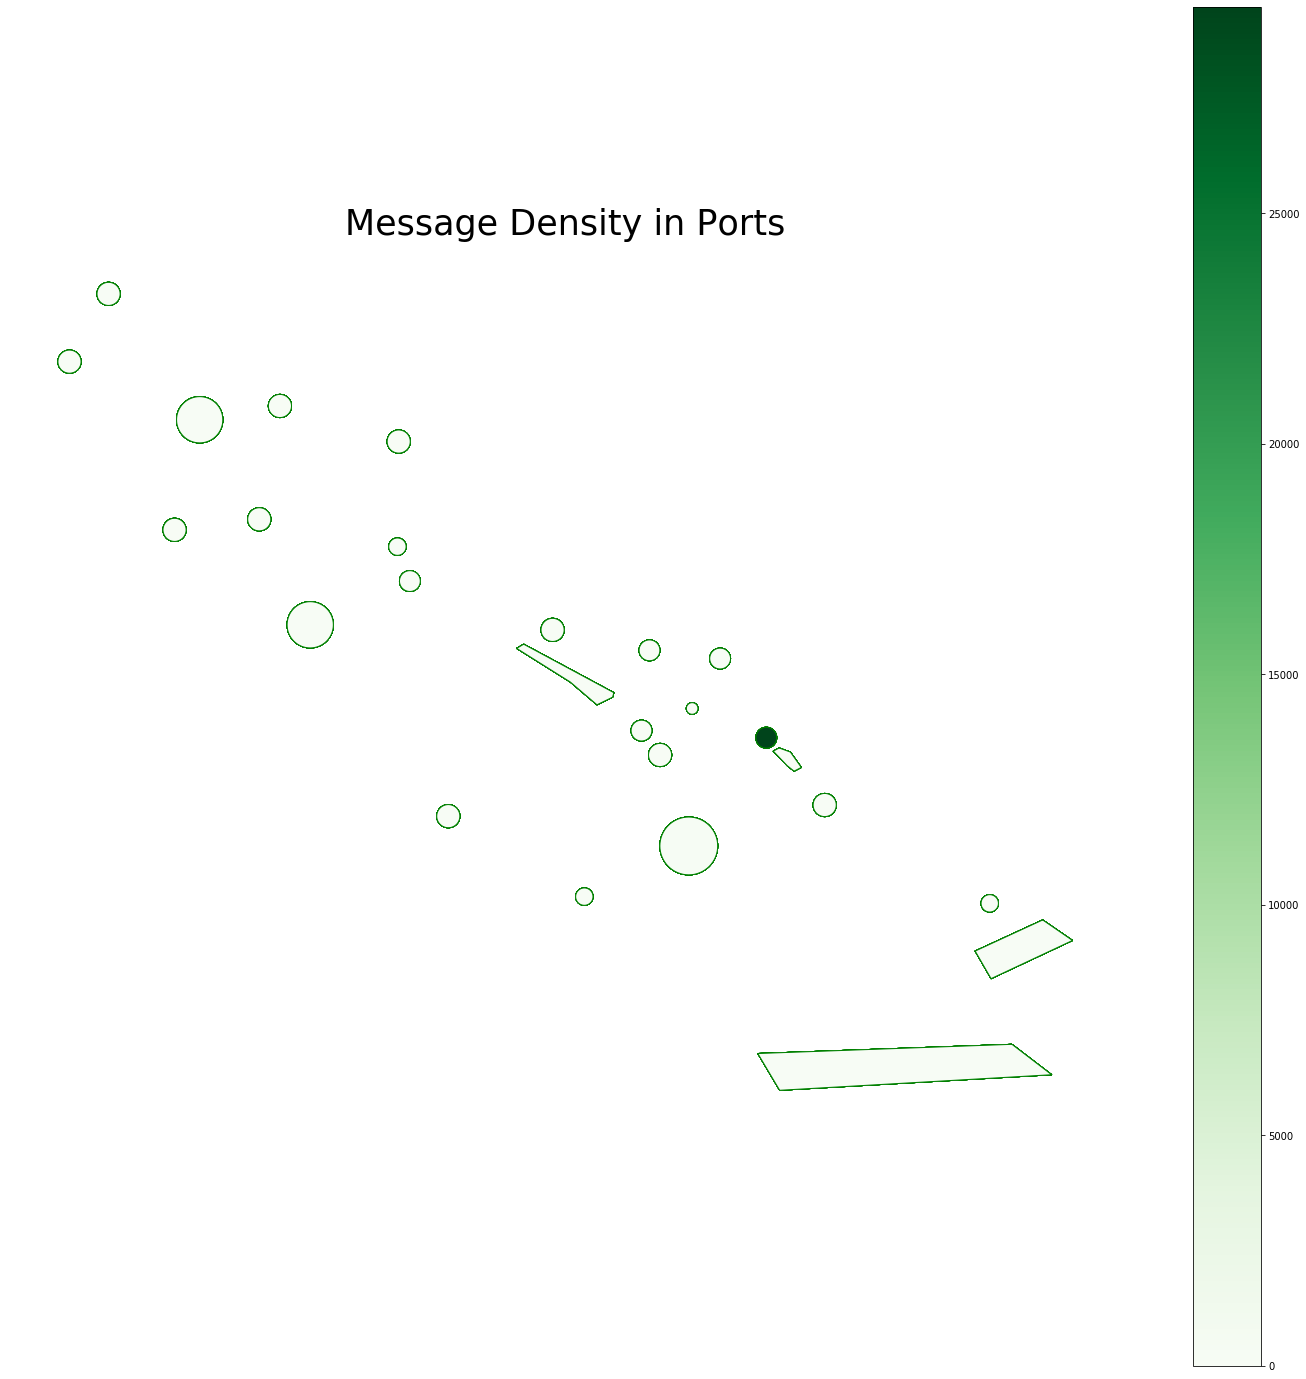

In [7]:
df_date = pd.to_datetime(df_AISData.event_time,format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')
df_groupedby_datehour = df_AISData.groupby([df_date.dt.date, df_date.dt.hour])

#initilize 3 separate subplots for 3 different figures.
fig1, ax1 = plt.subplots(figsize=(25,25))
fig2, ax2 = plt.subplots(figsize=(25,25))
fig3, ax3 = plt.subplots(figsize=(25,25))

#create directories if not exist; to store images
if not os.path.exists(os.getcwd()+'/imagesVesselsVisitPorts'):
    os.makedirs(os.getcwd()+'/imagesVesselsVisitPorts')
if not os.path.exists(os.getcwd()+'/imagesMessageIntersection'):
    os.makedirs(os.getcwd()+'/imagesMessageIntersection')
if not os.path.exists(os.getcwd()+'/imagesDensityColorcodeMap'):
    os.makedirs(os.getcwd()+'/imagesDensityColorcodeMap')

iteration=0
for name,df in df_groupedby_datehour:
    gdf = gpd.GeoDataFrame(df,crs={'init':'epsg:4326'},
                             geometry=[shapely.geometry.Point(xy) for xy in zip(df.x, df.y)])
    
    #Repeating steps objective 1:  
    # i) calling function to plot all vessels visited the port and saving resulting figure
    # ii) calling function to find all the AIS messages that intersect with ports and saving resulting figure
    fig1 = plot_all_vessels(df_ports,gdf,fig1,ax1,iteration)
    fig1.savefig('imagesVesselsVisitPorts/'+str(name)+".png")
    
    fig2 = plot_message_intersection_with_ports(df_ports,gdf,fig2,ax2,iteration)
    fig2.savefig('imagesMessageIntersection/'+str(name)+".png")
    
    #Repeating steps in objective 2: calling function to plot color code message density and saving resulting figure 
    fig3 = plot_message_density(df_ports,fig3,ax3,iteration)
    fig3.savefig('imagesDensityColorcodeMap/'+str(name)+".png")
    
    iteration=iteration+1

### 4.  Selecting a port and creating a temporal chart for the density of messages in that port.
The line chart below mention the temporal chart for Fairview Cove port. On the x-axis, datetime is plotted and on y-axis densities are plotted. 

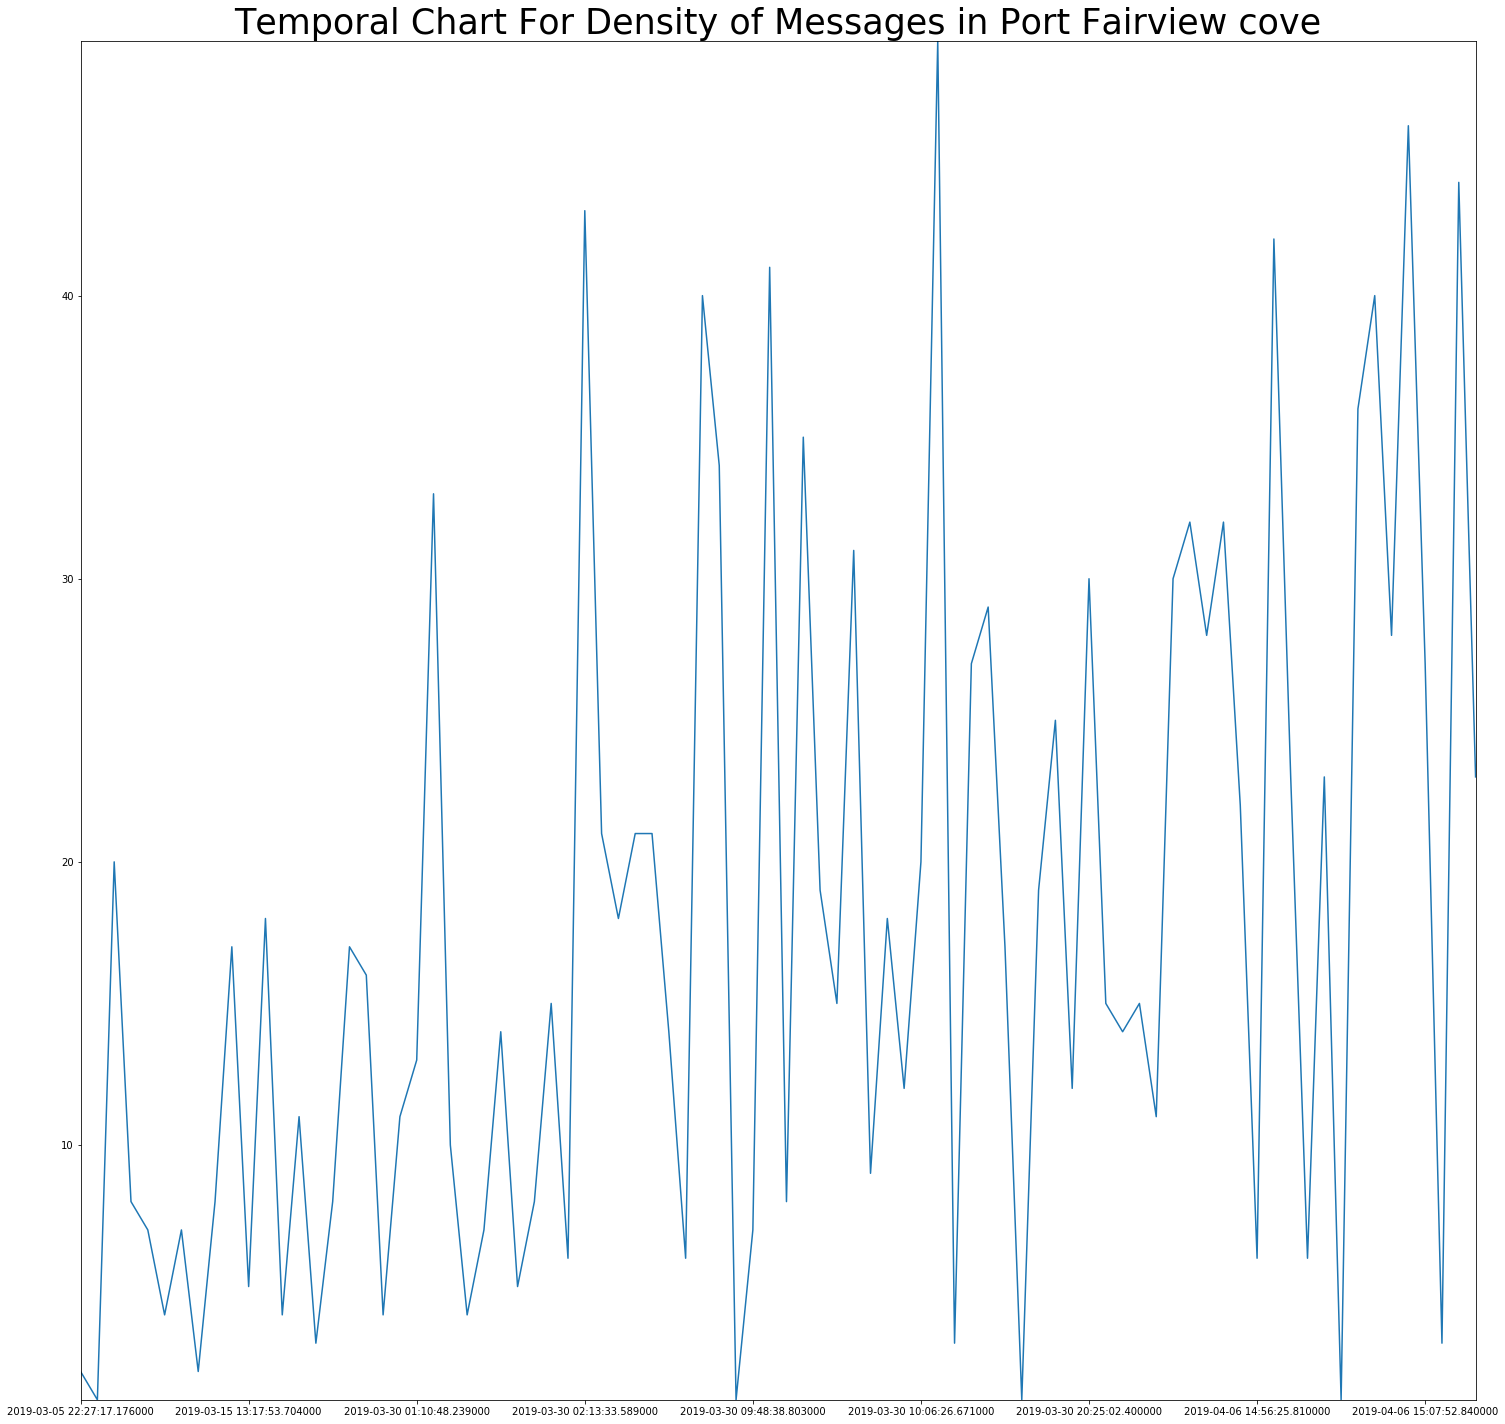

In [8]:
port_name='Fairview cove'
join_ais_ports=gpd.sjoin(gdf_AISData,df_ports,op='within',how='inner')

#get all correspoding data to specified port
df_selected_port=join_ais_ports.loc[join_ais_ports['index_right']==port_name,:]

#convert date with format
df_selected_date = pd.to_datetime(df_selected_port.event_time,format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')
grouped_selected_df = df_selected_port.groupby([df_selected_date.dt.date,df_selected_date.dt.hour])

df_tmp = pd.DataFrame(columns=['density', 'datetime'])
for name,df in grouped_selected_df:
    if(df.shape[0]>0):
        df_tmp = df_tmp.append({'density' : df.shape[0] , 'datetime' : df.iloc[0]["event_time"]},ignore_index=True)       

#plotting temporal char        
df_tmp["datetime"] = pd.to_datetime(df_tmp["datetime"],format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')
df_tmp = df_tmp.sort_values(by='datetime')
fig, ax = plt.subplots(figsize=(25,25))
ax.set_title('Temporal Chart For Density of Messages in Port '+port_name, fontdict={'fontsize': '35', 'fontweight' : '5'})
ax.set_xticklabels(df_tmp["datetime"])
ax.set_ylim(df_tmp["density"].min(),df_tmp["density"].max())
df_tmp['density'].plot(kind='line',ax=ax)


### 5. Using the concept drift methods on step 4 to find out if there is any drift in the data that can be detected. 


I have applied four methods to detect drift in data. The PageHinkley Methods successfully detect drift at two points. It can be observed from the output below that in PageHinkley drift is detected when there is sudden hike or fall in density. In following cases, density is increasing from 6 to 43 in first case, and decreasing from 40 to 28 in second case. More than 50% increase or decrease in densities is leading to drift in data. 

The parameter used in PageHinkley is threshold which is a threshold for change detection. If the observed mean is greater than this threshold then drift will be detected. Other two parameters are delta and alpha. Delta is a variable for conducting PageHinkley test and alpha variable is used to measure mean and observed value [2]. In DDM method, the parameters warning_level and out_control_level are used. If the algorithm identifies that there is increase in error then it warns user that an error may occur considering warning_level variable. The drift will detect when error cross the threshold [5].


In [9]:
ph = PageHinkley(threshold=60,delta=0.003, alpha=0.997)
isDetected = False
densities = df_tmp["density"] 
for i in range(len(densities)):
    ph.add_element(densities[i])
    if ph.detected_change():
        isDetected = True
        print('Change detected at density: ' + str(densities[i]) + ' and at index: ' + str(i))
        print('Previous density: ' + str(densities[i-1]) + ' and  previous index: ' + str(i-1)+"\n")
if(isDetected==False):
    print("No drift detected")

Change detected at density: 43 and at index: 30
Previous density: 6 and  previous index: 29

Change detected at density: 28 and at index: 78
Previous density: 40 and  previous index: 77



In [10]:
ddm = DDM(warning_level=3.0, out_control_level=4.0)
densities = df_tmp['density']
isDetected = False
for i in range(len(densities)):
    ddm.add_element(densities[i])
    if ddm.detected_change():
        isDetected = True
        print('Change detected at density: ' + str(densities[i]) + ' and at index: ' + str(i))
if(isDetected==False):
    print("No drift detected")

No drift detected


In [11]:
adwin = ADWIN(delta=0.005)
isDetected = False
for i in range(len(densities)):
    adwin.add_element(densities[i])
    if adwin.detected_change():
        isDetected = True
        print('Change detected in data: ' + str(densities[i]) + ' - of index: ' + str(i))
if(isDetected==False):
    print("No drift detected")

No drift detected


In [12]:
eddm = EDDM()
isDetected = False
for i in range(len(densities)):
    eddm.add_element(densities[i])
    if eddm.detected_change():
        isDetected = True
        print('Change detected in data at Density: ' + str(densities[i]) + 'and at time: ' 
              + df_tmp.iloc[i]["datetime"])
if(isDetected==False):
    print("No drift detected")

No drift detected


In [19]:
#this function prepares date to feed into DBScan
def pre_process_data():
    #this  function brings all the coordinates of AIS data that intersect with code
    df_AISData=pd.read_csv('AISData.csv')
    gdf_AISData = gpd.GeoDataFrame(df_AISData,
                                crs={'init': 'epsg:4326'},
                                geometry=[shapely.geometry.Point(xy) for xy in zip(df_AISData.x, df_AISData.y)])
    shape_Data=gpd.read_file('shapefile.shp')
    df_ports=shape_Data.set_index(['port_name'])
    join_aisports=gpd.sjoin(gdf_AISData,df_ports,op='within',how='inner')
    df_coord = pd.DataFrame(columns=['x', 'y'])
    df_tmp = pd.DataFrame(columns=['density', 'datetime'])
    
    for port in set(join_aisports['index_right']):
        df=join_aisports.loc[join_aisports['index_right']==port,:]
        if df.shape[0]>0:
            df_coord = df_coord.append(df[['x','y']])
            df_tmp = df_tmp.append({'density' : df.shape[0] , 'datetime' : df.iloc[0]["event_time"]},ignore_index=True)
        
    return df_coord,df_tmp
    
def run_dbscan(df,dim):
    X = StandardScaler().fit_transform(df)
    ds = DBSCAN(eps=0.3, min_samples=10).fit(X)
    sample_mask = np.zeros_like(ds.labels_, dtype=bool)
    sample_mask[ds.core_sample_indices_] = True
    labels = ds.labels_

    no_of_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    no_of_noise = list(labels).count(-1)

    print('Number of clusters: %d' % no_of_clusters)
    print('Number of noise points: %d' % no_of_noise)

    unq_labels = set(labels)
    array_colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unq_labels))]
    for k, column in zip(unq_labels, array_colors):
        if k == -1:
            column = [0, 0, 0, 1]

        class_memmask = (labels == k)

        xy_cord = X[class_memmask & sample_mask]
        plt.plot(xy_cord[:, 0], xy_cord[:, dim], 'o', markerfacecolor=tuple(column),
                 markeredgecolor='k', markersize=14)

        xy_cord = X[class_memmask & ~sample_mask]
        plt.plot(xy_cord[:, 0], xy_cord[:, dim], 'o', markerfacecolor=tuple(column),
                 markeredgecolor='k', markersize=6)

    plt.show()

### 6. Cluster the ports based on their message density using DBSCAN and categorize the ports based on traffic (message density).

I ran DBSCAN on two scenerios.
1. Cluster the ports based on message densities.
2. Cluster the ports based on coordinates that intersecting with ports while considering message densities.

For first scenerio, there is only one cluster formed. In DBScan, only variable is passed that is message density. The reason of getting only cluster is that there is only feauture, which is not sufficient to generate different clusters.

In second scenerio, I am passing coordinates (x and y) to DBScan. These coordinates are intersection with ports. There are four clusters formed from 26 ports data. The cluster is formed on basis of density (number of visit to each port) and how these ports are frequently visited.   

Number of clusters: 1
Number of noise points: 1


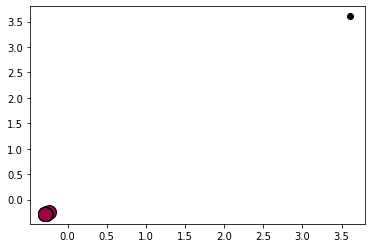

In [21]:
df_coord,df_tmp = pre_process_data()
run_dbscan(df_tmp[["density"]],0)

Number of clusters: 4
Number of noise points: 30


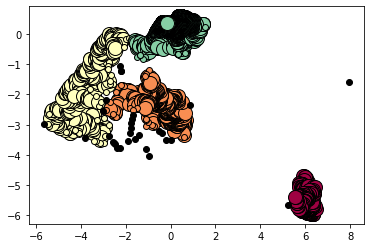

In [22]:
run_dbscan(df_coord[['x','y']][0:20000],1)

### References:

[1] “HTML Color Codes,” HTML Color Codes, 03-Sep-2015. [Online]. Available: https://htmlcolorcodes.com/. \
[2] “skmultiflow.drift_detection.page_hinkley,” scikit. [Online]. Available: https://scikit-multiflow.github.io  /scikit-multiflow/_autosummary/skmultiflow.drift_detection.page_hinkley.html. \
[3] “Demo of DBSCAN clustering algorithm,” scikit. [Online]. Available: https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py. \
[4] “skmultiflow.drift_detection.adwin,” scikit. [Online]. Available: https://scikit-multiflow.github.io/scikit-multiflow/_autosummary/skmultiflow.drift_detection.adwin.html. \
[5] “skmultiflow.drift_detection.ddm,” scikit. [Online]. Available: https://scikit-multiflow.github.io/scikit-multiflow/_autosummary/skmultiflow.drift_detection.ddm.html. \
[6] “skmultiflow.drift_detection.eddm,” scikit. [Online]. Available: https://scikit-multiflow.github.io/scikit-multiflow/_autosummary/skmultiflow.drift_detection.eddm.html. \
[7] “Lab_Spatio.” [Online]. Available: https://dal.brightspace.com/d2l/le/content/98749/viewContent/1338394/View. \
[8] “pandas.to_datetime,” pandas.to_datetime - pandas 0.25.0 documentation. [Online]. Available: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html. \
[9] T. Tak, “matplotlib.cm.ScalarMappable Example,” Program Talk. [Online]. Available: https://programtalk.com/python-examples/matplotlib.cm.ScalarMappable/. \
[10] D. School, “When should I use a ‘groupby’ in pandas?,” YouTube, 19-May-2016. [Online]. Available: https://www.youtube.com/watch?v=qy0fDqoMJx8.
 













